<a href="https://colab.research.google.com/github/SibeleTatiana/D_L-Models/blob/main/C%C3%B3pia_de_moledo_plantas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import imghdr
from PIL import Image

In [4]:
from zipfile import ZipFile

# Enviar o arquivo manualmente no Colab e ajustar o nome se necessário
zip_path = "/content/plantas.zip"
extract_path = "/content/Plantas_test_treino"

# Descompactar
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [5]:
def limpar_e_converter_imagens(diretorio):
    erros = []
    for root, dirs, files in os.walk(diretorio):
        for file in files:
            path = os.path.join(root, file)
            try:
                with Image.open(path) as img:
                    img.convert("RGB")  # força formato RGB
                    img.save(path)      # reescreve a imagem
            except Exception as e:
                erros.append(path)
                os.remove(path)
                print(f"Removido inválido: {path}")
    print(f"\nTotal de imagens removidas: {len(erros)}")

limpar_e_converter_imagens("/content/Plantas_test_treino")


Removido inválido: /content/Plantas_test_treino/Violeta_Palustre/3.jpg
Removido inválido: /content/Plantas_test_treino/Violeta_Palustre/10.jpg
Removido inválido: /content/Plantas_test_treino/Violeta_Palustre/7.jpg
Removido inválido: /content/Plantas_test_treino/Violeta_Palustre/12.jpg
Removido inválido: /content/Plantas_test_treino/Violeta_Palustre/11.jpg
Removido inválido: /content/Plantas_test_treino/Violeta_Palustre/4.jpg
Removido inválido: /content/Plantas_test_treino/Violeta_Palustre/6.jpg
Removido inválido: /content/Plantas_test_treino/Violeta_Palustre/8.jpg
Removido inválido: /content/Plantas_test_treino/Violeta_Palustre/5.jpg
Removido inválido: /content/Plantas_test_treino/Violeta_Palustre/2.jpg
Removido inválido: /content/Plantas_test_treino/Violeta_Palustre/9.jpg
Removido inválido: /content/Plantas_test_treino/Violeta_Palustre/13.jpg

Total de imagens removidas: 12


In [6]:

# Parâmetros
base_dir = "/content/Plantas_test_treino"
img_height = 224
img_width = 224
batch_size = 16
seed = 123


In [7]:

# Remover imagens inválidas
for root, dirs, files in os.walk(base_dir):
    for file in files:
        file_path = os.path.join(root, file)
        if imghdr.what(file_path) is None:
            print(f"Removendo inválido: {file_path}")
            os.remove(file_path)


In [8]:
# Carregar o dataset
train_ds_original = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds_original = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Obter classes antes do prefetch
class_names = train_ds_original.class_names
num_classes = len(class_names)

# Otimizar com prefetch depois
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds_original.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds_original.prefetch(buffer_size=AUTOTUNE)

print("Classes:", class_names)


Found 49 files belonging to 3 classes.
Using 40 files for training.
Found 49 files belonging to 3 classes.
Using 9 files for validation.
Classes: ['Sábila', 'Violeta_Palustre', 'suculenta']


In [9]:

# Modelo CNN
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Treinar o modelo
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.4203 - loss: 256.7969 - val_accuracy: 0.5556 - val_loss: 288.2423
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7641 - loss: 72.7049 - val_accuracy: 0.6667 - val_loss: 81.3618
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.6313 - loss: 38.2929 - val_accuracy: 0.5556 - val_loss: 36.6676
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.7203 - loss: 8.1842 - val_accuracy: 0.5556 - val_loss: 5.9137
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8625 - loss: 1.6736 - val_accuracy: 0.5556 - val_loss: 5.4057
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8953 - loss: 0.1873 - val_accuracy: 0.4444 - val_loss: 1.8552
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9594 - loss: 0.1095 - val_accuracy: 0.5556 - val_loss: 2.8586
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9875 - loss: 0.0336 - val_accuracy: 0.5556 - val_loss: 3.4289
Epoc

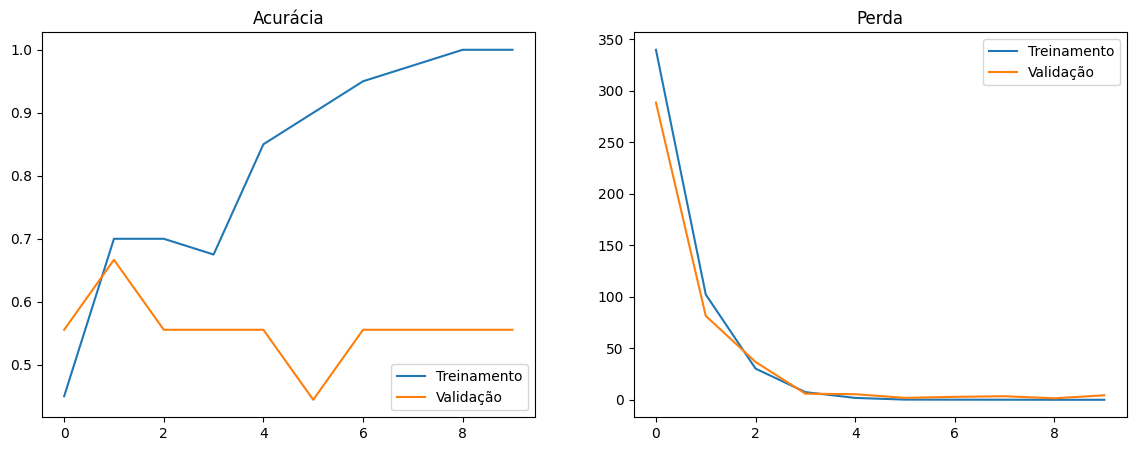

In [11]:

# Visualizar acurácia
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Treinamento')
plt.plot(epochs_range, val_acc, label='Validação')
plt.legend(loc='lower right')
plt.title('Acurácia')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Treinamento')
plt.plot(epochs_range, val_loss, label='Validação')
plt.legend(loc='upper right')
plt.title('Perda')

plt.show()
